In [75]:
import numpy as np
import tensorflow as tf

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

corpus = api.load('text8')
w2v = Word2Vec(corpus)
w2v.wv.add('<END>', np.random.rand(100))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
    
    def call(self, input_features):
        return self.output_layer(self.hidden_layer(input_features))

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        return self.output_layer(self.hidden_layer(code))

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    return self.decoder(self.encoder(input_features))

In [0]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [0]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

In [0]:
def train_loop(model, opt, loss, dataset, epochs, print_steps):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    if (epoch + 1)%print_steps == 0:
      print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [108]:
input_text = ["it is a good day to start",
              "that sport car is dark red and i love it",
              "everybody likes dark theme when coding",
              "i like to move it move it",
              "i am going to code",
              ]

input_text = tf.keras.preprocessing.sequence.pad_sequences(
            [i.split() for i in input_text],
            padding='post', dtype=object, value='<END>')

seq_lenght = len(input_text[0])
vector_lenght = seq_lenght*100

x_train = [[w2v[j] for j in i] for i in input_text]
x_train = np.asarray(x_train, dtype=np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], vector_lenght))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Epoch 1000/5000. Loss: 0.9618300795555115
Epoch 2000/5000. Loss: 0.9292380809783936
Epoch 3000/5000. Loss: 0.9168202877044678
Epoch 4000/5000. Loss: 0.905506432056427
Epoch 5000/5000. Loss: 0.8959076404571533


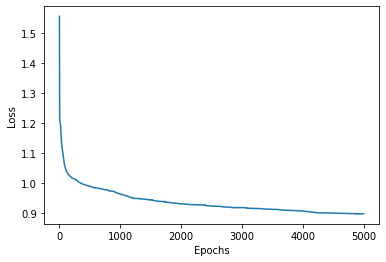

In [109]:
model = Autoencoder(intermediate_dim=128, original_dim=vector_lenght)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

train_loop(model, opt, loss, training_dataset, 5000, 1000)

import matplotlib.pyplot as plt
plt.plot(range(len(model.loss)), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [110]:
for predict in model(x_train):
  predict = predict.numpy().reshape(seq_lenght, 100)
  result = [w2v.wv.similar_by_vector(i)[0][0] for i in predict]
  print()
  print('     ',*[i for i in result if not i=='<END>'])
  print('_____________________________________________________________________')


      it is a good day to start
_____________________________________________________________________

      that sport car is dark red and i love it
_____________________________________________________________________

      everyone likes dark theme when coding
_____________________________________________________________________

      i like to move it move it
_____________________________________________________________________

      i am going to code
_____________________________________________________________________


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
